In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control.matlab
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from examples.RLC.symbolic_RLC import fxu_ODE, fxu_ODE_nl
from examples.RLC.loader import rlc_loader


![RLC circuit](../doc/RLC_circuit.png)

In [2]:
def saturation_formula(current_abs):
    sat_ratio = (1/np.pi*np.arctan(-1.0*(np.abs(current_abs)-5))+0.5)*0.9 + 0.1
    return sat_ratio

def saturation_formula_paper(current_abs): #! TYPO in paper
    sat_ratio = 0.9/np.pi * np.arctan(-5.0*np.abs(current_abs)-5)+0.5+0.1
    return sat_ratio

In [3]:
saturation_formula(0), saturation_formula_paper(0)

(0.9434503376298989, 0.20654966237010106)

Text(0, 0.5, 'Inductance $L$ ($\\mu$H)')

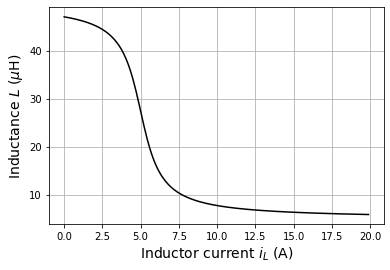

In [4]:
L_0nom = 50e-6 # 50 µH
inductor_current = np.arange(0., 20., 0.1)
plt.plot(inductor_current, L_0nom * 1e6 * saturation_formula(inductor_current), 'k')
plt.grid()
plt.xlabel('Inductor current $i_L$ (A)', fontsize=14)
plt.ylabel('Inductance $L$ ($\mu$H)', fontsize=14)

In [5]:
# Input characteristics #
len_sim = 5e-3 # milliseconds
Ts = 1e-6  # 1 µs
omega_input = 80e3 # 80 kHz # bandwidth of the filter
tau_input = 1 / omega_input
std_input = 80 # V

seed = 1
rng = np.random.default_rng(seed=seed)

##### Input description according to paper:
The input is a filtered white noise with bandwidth 80, 90, 100, 100 kHz and standard deviation 80, 70, 70, 70 V for the training, test, transfer, and evaluation datasets, respectively. In the training and transfer datasets, the output v_C is corrupted by an
additive white noise term.

In [6]:
# white noise is a random process
# white noise has all frequencies -> not possible -> need filter
# input transfer function -> this is the filter used to filter the white noise
Hu = control.TransferFunction([1], [1 / omega_input, 1])
Hu

TransferFunction(array([1]), array([1.25e-05, 1.00e+00]))

In [7]:
Hu = Hu*Hu
Hu

TransferFunction(array([1.]), array([1.5625e-10, 2.5000e-05, 1.0000e+00]))

In [8]:
# discretize the filter < through this filter the random process is passed
Hud = control.matlab.c2d(Hu, Ts)
Hud

TransferFunction(array([0.00303435, 0.00287675]), array([ 1.        , -1.84623269,  0.85214379]), 1e-06)

Text(0.5, 1.0, 'example input (unfiltered)')

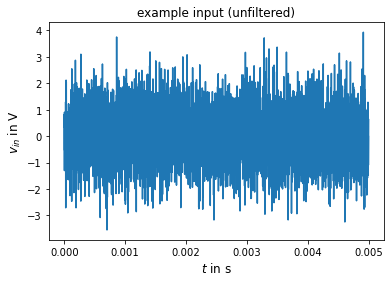

In [9]:
# generate the white noise 
#? do not use the 'initial skip samples'
N_sim = int(len_sim // Ts)
e = rng.standard_normal(N_sim)
te = np.arange(N_sim) * Ts
plt.plot(te, e)
plt.ylabel(r'$v_{in}$ in V', fontsize=12)
plt.xlabel(r'$t$ in s', fontsize=12)
plt.title('example input (unfiltered)')

In [10]:
# filter the white noise (-> colored noise)
_, u = control.forced_response(Hu, te, e, return_x=False)

Text(0.5, 1.0, 'example input (filtered, but still unscaled)')

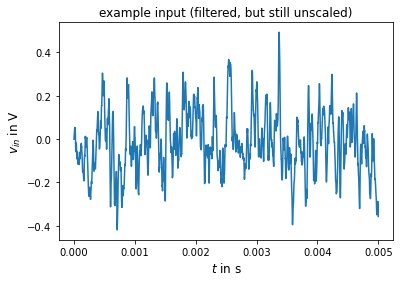

In [11]:
plt.plot(te, u)
plt.ylabel(r'$v_{in}$ in V', fontsize=12)
plt.xlabel(r'$t$ in s', fontsize=12)
plt.title('example input (filtered, but still unscaled)')

Text(0.5, 1.0, 'example input (filtered and scaled)')

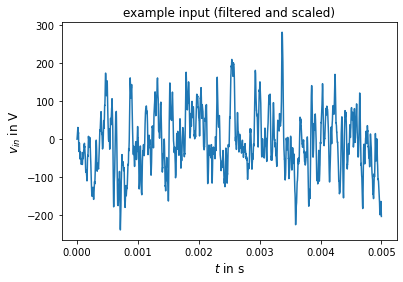

In [12]:
# scaled input signal
u = u / np.std(u) * std_input
plt.plot(te, u)
plt.ylabel(r'$v_{in}$ in V', fontsize=12)
plt.xlabel(r'$t$ in s', fontsize=12)
plt.title('example input (filtered and scaled)')

#### Now: simulate the system with the generated (random) input signal

Output of the system: capacitor voltage v_C and inductor current i_L

In [13]:
t_sim = np.arange(N_sim) * Ts
u_func = interp1d(t_sim, u, kind='zero', fill_value="extrapolate")

def f_ODE(t, x):
    u = u_func(t).ravel()
    return fxu_ODE(t, x, u)
    
def f_ODE_nl(t, x):
    u = u_func(t).ravel()
    return fxu_ODE_nl(t, x, u)

In [14]:
# initial conditions 
x0 = np.zeros(2)
f_ODE(0.0, x0), f_ODE_nl(0.0, x0)

(array([0., 0.]), array([0., 0.]))

In [15]:
# Simulate Linear and Non-Linear
t_span = (t_sim[0], t_sim[-1])
y_lin = solve_ivp(f_ODE, t_span, x0, t_eval=t_sim)  # Linear
y_nonlin = solve_ivp(f_ODE_nl, t_span, x0, t_eval=t_sim)  # Non-Linear

In [16]:
# System states over time
# System State x = [v_c, i_l].T
x_lin = y_lin.y
x_nonlin = y_nonlin.y
x_lin.shape, x_nonlin.shape

((2, 5000), (2, 5000))

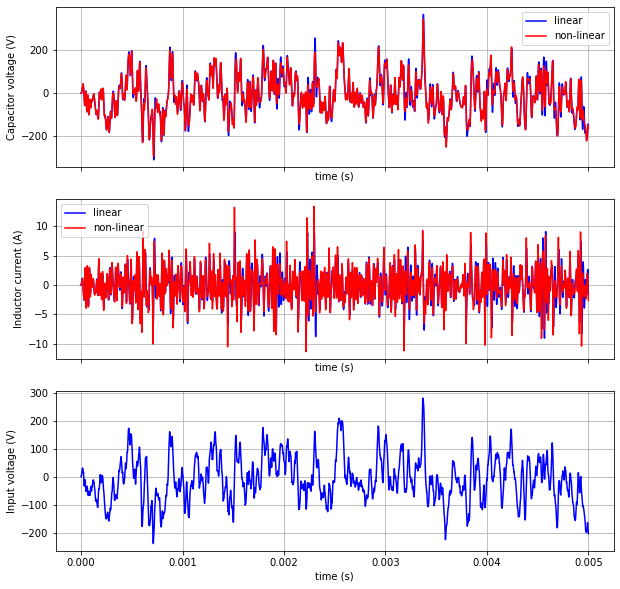

In [17]:
# plot the outputs
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].plot(t_sim, x_lin[0,:], 'b', label='linear')  # Linear
ax[0].plot(t_sim, x_nonlin[0, :], 'r', label='non-linear')  # Non-Linear
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Capacitor voltage (V)')
ax[0].legend()

ax[1].plot(t_sim, x_lin[1, :], 'b', label='linear')
ax[1].plot(t_sim, x_nonlin[1, :], 'r', label='non-linear')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Inductor current (A)')
ax[1].legend()

ax[2].plot(t_sim, u, 'b')
ax[2].set_xlabel('time (s)')
ax[2].set_ylabel('Input voltage (V)')
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
plt.show()

In [18]:
scale_x = [90., 3.]
scale_u = std_input

In [19]:
x_lin = (x_lin.T / scale_x).T
x_nonlin = (x_nonlin.T / scale_x).T
u = u / scale_u

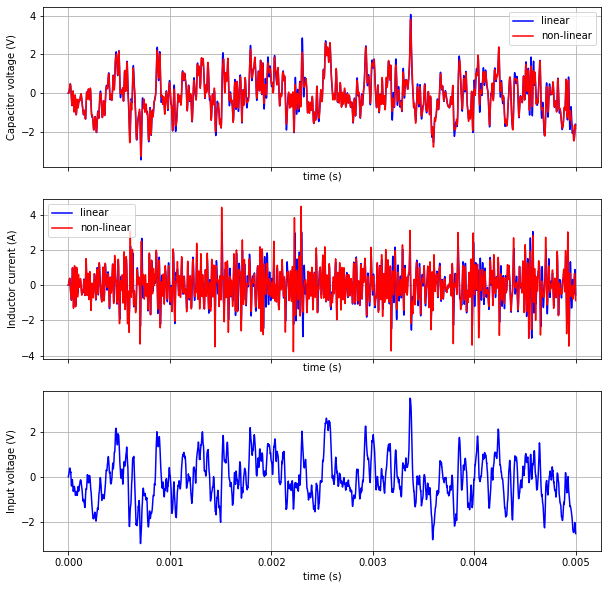

In [20]:
# plot the outputs
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].plot(t_sim, x_lin[0,:], 'b', label='linear')  # Linear
ax[0].plot(t_sim, x_nonlin[0, :], 'r', label='non-linear')  # Non-Linear
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Capacitor voltage (V)')
ax[0].legend()

ax[1].plot(t_sim, x_lin[1, :], 'b', label='linear')
ax[1].plot(t_sim, x_nonlin[1, :], 'r', label='non-linear')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Inductor current (A)')
ax[1].legend()

ax[2].plot(t_sim, u, 'b')
ax[2].set_xlabel('time (s)')
ax[2].set_ylabel('Input voltage (V)')
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

## Check Dataset scale

In [21]:
COL_T = ['time']
COL_X = ['V_C', 'I_L']
COL_U = ['V_IN']
COL_Y = ['V_C']

DATA_DIR = "/home/max/phd/meta/RNN-adaptation/examples/RLC/data"

def rlc_loader(dataset, dataset_type="nl", output='V_C', noise_std=0.1, dtype=np.float32, scale=True, n_data=-1):
    filename = f"RLC_data_{dataset}_{dataset_type}.csv"
    df_data = pd.read_csv(Path(DATA_DIR)/ filename)
    t = np.array(df_data[['time']], dtype=dtype)
    u = np.array(df_data[['V_IN']], dtype=dtype)
    y = np.array(df_data[[output]], dtype=dtype)
    x = np.array(df_data[['V_C', 'I_L']], dtype=dtype)
    y += np.random.randn(*y.shape) * noise_std
    if scale:
        u = u/100
        y = y/100
        x = x/[100, 6]

    if n_data > 0:
        t = t[:n_data, :]
        u = u[:n_data, :]
        y = y[:n_data, :]
        x = x[:n_data, :]
    return t, u, y, x

In [22]:
t, u, y, x = rlc_loader("train", "nl", noise_std=0.0, scale=False)

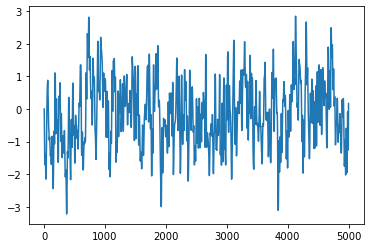

In [23]:
plt.plot(y) # output voltage v_c

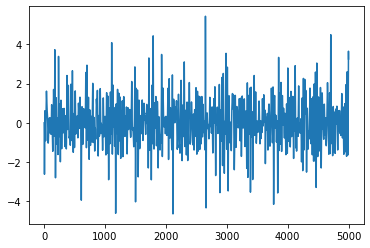

In [24]:
plt.plot(x[:,1]) # current il

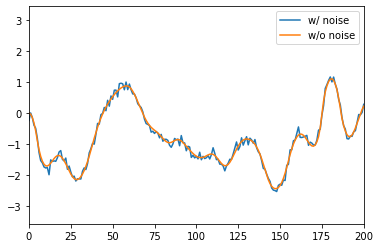

In [28]:
t, u, y_n, x = rlc_loader("train", "nl", noise_std=0.1, scale=False)
plt.plot(y_n, label='w/ noise')
plt.plot(y, label='w/o noise')
plt.xlim(0,200)
plt.legend()

In [26]:
x.shape

(5000, 2)